In [1]:
import pandas as pd

In [2]:
model_filter = {
    'FacEval': ['bart_large', 'co-ref bart large', 'condigsum bart large','gpt4-32k-0613','mv-bart_large', 'alpaca-13b'],
    'SAMSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b'],
    'DialogueSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b']

}
def read_filter(filename):
    df = pd.read_csv(filename)
    df_datasets = []
    unique_datasets = list(set(df['origin'].values))
    for dataset in unique_datasets: 
        df_origin = df[df['origin'] == dataset]
        df_origin = df_origin[df_origin['model'].isin(model_filter[dataset])]
        # print(len(df_origin))
        unique_docids = list(set(df_origin['docid'].values))
        #### test ###
        num_models = []
        for udocid in unique_docids:
            df_docid = df_origin[df_origin['docid'] == udocid]
            num_models.append(len(list(set(df_docid['model'].values))))
        # print(df_docid)
        assert(len(set(num_models)) == 1) 
        df_datasets.append(df_origin)
    df_filtered = pd.concat(df_datasets)
    assert(len(df_filtered) <= len(df))
    return df_filtered


In [3]:
df_scored = read_filter('/home/ramprasad.sa/factual_evaluation_source_based/datasets/scored/xformer_llm_annotated_scored.csv')
df_scored

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,...,origin,dialogue_atomic_facts,SummaC-ZS_score,SummaC-conv_score,QuestEval_score,QAFactEval_scores,QAFactEval-Afacts_scores,SummaC-ZS-Afacts_score,SummaC-conv-Afacts_score,QuestEval-Afacts_score
474,1050,1050,0,0,0,13864432,condigsum bart large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
475,1051,1051,1,1,1,13864432,co-ref bart large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
476,1052,1052,2,2,2,13864432,mv-bart_large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
477,1053,1053,3,3,3,13864432,bart_large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
478,1054,1054,4,4,4,13864432,gpt4-32k-0613,[],[],"Mary currently resides in Southampton, having ...",...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.788315,0.222796,0.589610,3.370152,5.006689,0.758831,0.222796,0.870013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,1045,1045,1945,2007,2007,13681241,BART,[],[],Callum is busy.,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0.187744,0.219868,0.393076,4.284290,4.909194,0.762695,0.415731,0.602062
470,1046,1046,1946,2008,2008,13681241,MV-BART,[],[],Callum is still busy and sorry.,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,-0.124634,0.207674,0.434746,4.290496,5.022563,0.000488,0.529741,0.602378
471,1047,1047,1947,2009,2009,13681241,UniLM,[],[],Callum is still busy .,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0.206299,0.215659,0.426372,4.213919,4.949706,0.644653,0.250367,0.605626
472,1048,1048,1948,2010,2010,13681241,gpt4-32k-0613,[],[],"Jair checks if Callum is still busy, and Callu...",...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,-0.856552,0.205960,0.372612,2.014265,3.773449,-0.430420,0.225659,0.705431


In [8]:
df_scored.keys()

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'docid', 'model', 'nonfactual_spans', 'evidence',
       'summary', 'factual_error', 'error_type', 'dialogue', 'origin',
       'dialogue_atomic_facts', 'SummaC-ZS_score', 'SummaC-conv_score',
       'QuestEval_score', 'QAFactEval_scores', 'QAFactEval-Afacts_scores',
       'SummaC-ZS-Afacts_score', 'SummaC-conv-Afacts_score',
       'QuestEval-Afacts_score'],
      dtype='object')

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score


df_plot_model_category = {
'dataset': [],
'model': [],
'auc_score': [],
'metric': []
}

unique_datasets = ['DialogueSum', 'SAMSum', 'FacEval']
# metrics = ['SummaC-ZS_score', 'SummaC-conv_score', 'QuestEval_score',
#        'QAFactEval_scores', 'ChatGPT-direct_assesment_label']

metrics = ['SummaC-ZS-Afacts_score', 'SummaC-conv-Afacts_score',
       'QuestEval-Afacts_score', 'QAFactEval-Afacts_scores']
for dataset in unique_datasets:
    print(dataset)
    df_dataset = df_scored[df_scored['origin'] == dataset ]
    df_dataset_llm = df_dataset[df_dataset['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]
    df_dataset_xformer = df_dataset[~df_dataset['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]
    for metric in metrics:
        llm_metric_scores= df_dataset_llm[metric].values
        xformer_metric_scores = df_dataset_xformer[metric].values

        metric = metric.split('_score')[0]
        llm_auc_score = 1 - roc_auc_score(df_dataset_llm['factual_error'].values, llm_metric_scores)
        df_plot_model_category['dataset'].append(dataset)
        df_plot_model_category['model'].append('LLM')
        df_plot_model_category['metric'].append(metric.split('_')[0].strip())
        df_plot_model_category['auc_score'].append(llm_auc_score)

        xformer_auc_score = 1 - roc_auc_score(df_dataset_xformer['factual_error'].values, xformer_metric_scores)
        df_plot_model_category['dataset'].append(dataset)
        df_plot_model_category['model'].append('XFORMER')
        df_plot_model_category['metric'].append(metric.split('_')[0].strip())
        df_plot_model_category['auc_score'].append(xformer_auc_score)
        
#     factual_proportion_dataset = list(df_plot_dataset['factual_proportion'].values)
    
#     llm_prop = [factual_proportion_dataset[idx] for idx, model in enumerate(list(df_plot_dataset['model'].values)) if model in ['gpt4-32k-0613', 'alpaca-13b']]
#     xformer_prop = [factual_proportion_dataset[idx] for idx, model in enumerate(list(df_plot_dataset['model'].values)) if model not in ['gpt4-32k-0613', 'alpaca-13b']]
#     print(dataset, llm_prop, xformer_prop, set(list(df_plot_dataset['model'].values)))
#     # print(df_plot_dataset)
#     df_plot_model_category['dataset'] += [dataset.split('_')[-1]] * 2
#     df_plot_model_category['model'] += ['XFORMER', 'LLM'] 
#     df_plot_model_category['factual_proportion'] += [np.mean(xformer_prop), np.mean(llm_prop)]

# df_plot_model_category = pd.DataFrame(df_plot_model_category)
# df_plot_model_category
    

DialogueSum
SAMSum
FacEval


In [15]:
# df_dataset_xformer

In [16]:
df_plot_model_category = pd.DataFrame(df_plot_model_category)
df_plot_model_category

,dataset,model,auc_score,metric
0,DialogueSum,LLM,0.639435,SummaC-ZS-Afacts
1,DialogueSum,XFORMER,0.612823,SummaC-ZS-Afacts
2,DialogueSum,LLM,0.559122,SummaC-conv-Afacts
3,DialogueSum,XFORMER,0.491764,SummaC-conv-Afacts
4,DialogueSum,LLM,0.585688,QuestEval-Afacts
5,DialogueSum,XFORMER,0.570688,QuestEval-Afacts
6,DialogueSum,LLM,0.618704,QAFactEval-Afacts
7,DialogueSum,XFORMER,0.628423,QAFactEval-Afacts
8,SAMSum,LLM,0.635514,SummaC-ZS-Afacts
9,SAMSum,XFORMER,0.615590,SummaC-ZS-Afacts


([0, 1, 2, 3],
 [Text(0, 0, 'SummaC-ZS-Afacts'),
  Text(1, 0, 'SummaC-conv-Afacts'),
  Text(2, 0, 'QuestEval-Afacts'),
  Text(3, 0, 'QAFactEval-Afacts')])

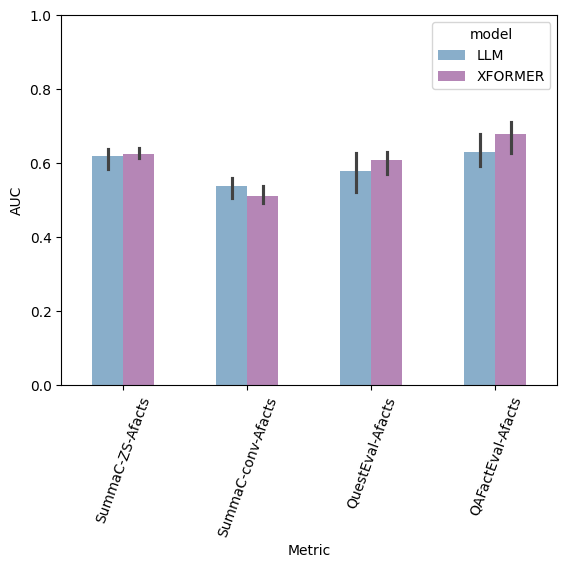

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(df_plot_model_category, x = 'metric', y = 'auc_score', hue = 'model', palette = ["#7eb0d5", "#bd7ebe"], width = 0.5)
ax.set_ylim(0,1)
ax.set(xlabel = 'Metric', ylabel = 'AUC')
plt.xticks(rotation=70)
# plt.savefig('llm_vs_transfomrers_errors.pdf')

In [13]:
df_scored

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,...,origin,dialogue_atomic_facts,SummaC-ZS_score,SummaC-conv_score,QuestEval_score,QAFactEval_scores,QAFactEval-Afacts_scores,SummaC-ZS-Afacts_score,SummaC-conv-Afacts_score,QuestEval-Afacts_score
474,1050,1050,0,0,0,13864432,condigsum bart large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
475,1051,1051,1,1,1,13864432,co-ref bart large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
476,1052,1052,2,2,2,13864432,mv-bart_large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
477,1053,1053,3,3,3,13864432,bart_large,[],[],Mary lives in Southampton. She moved there in ...,...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.479731,0.488206,0.558296,3.044900,4.977778,0.978738,0.769749,0.694343
478,1054,1054,4,4,4,13864432,gpt4-32k-0613,[],[],"Mary currently resides in Southampton, having ...",...,FacEval,Mary currently lives in Southampton.\nMary mov...,0.788315,0.222796,0.589610,3.370152,5.006689,0.758831,0.222796,0.870013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,1045,1045,1945,2007,2007,13681241,BART,[],[],Callum is busy.,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0.187744,0.219868,0.393076,4.284290,4.909194,0.762695,0.415731,0.602062
470,1046,1046,1946,2008,2008,13681241,MV-BART,[],[],Callum is still busy and sorry.,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,-0.124634,0.207674,0.434746,4.290496,5.022563,0.000488,0.529741,0.602378
471,1047,1047,1947,2009,2009,13681241,UniLM,[],[],Callum is still busy .,...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0.206299,0.215659,0.426372,4.213919,4.949706,0.644653,0.250367,0.605626
472,1048,1048,1948,2010,2010,13681241,gpt4-32k-0613,[],[],"Jair checks if Callum is still busy, and Callu...",...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,-0.856552,0.205960,0.372612,2.014265,3.773449,-0.430420,0.225659,0.705431


In [52]:
df_span = pd.read_csv('/home/ramprasad.sa/factual_evaluation_source_based/datasets/scored/xformer_llm_pred_span_gpt.csv')
df_span

,Unnamed: 0.1,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,factual_error,error_type,dialogue,origin,dialogue_atomic_facts,Errors,GPTSpan-ZS_f1_len,GPTSpan-ZS_f1_exact,GPTSpan-ZS_text,GPTSpan-ZS-Afact_f1_len,GPTSpan-ZS-Afact_f1_exact,GPTSpan-ZS-Afact-ZS_text
0,6,6,test_133,CODS,[],[],#Person1# and #Person2# talk about the heavy s...,0,[],"#Person1#: It was a heavy storm last night, wa...",DialogueSum,There was a heavy storm last night.\nThe wind ...,0,1.000000,1.0,['No inconsistent spans.'],0.000000,0.0,['#Person1# and #Person2# talk about the heavy...
1,7,7,test_133,BART,['They '],[],#Person1# and #Person2# talk about the heavy s...,1,['Intrinsic_Error'],"#Person1#: It was a heavy storm last night, wa...",DialogueSum,There was a heavy storm last night.\nThe wind ...,1,1.000000,0.0,"['""They think the weather is terrible but they...",0.666667,0.0,['#Person1# and #Person2# talk about the heavy...
2,8,8,test_133,MV-BART,"[""it's April "", 'They both ']",[],#Person1# and #Person2# are talking about the ...,1,['Intrinsic_Error'],"#Person1#: It was a heavy storm last night, wa...",DialogueSum,There was a heavy storm last night.\nThe wind ...,2,0.666667,0.0,"['""They both think the weather is terrible""']",1.000000,0.0,"['""They both think the weather is terrible""', ..."
3,9,9,test_133,UniLM,"['person1 ', 'but ']",[],person1 and person2 talk about the heavy storm...,1,['Intrinsic_Error'],"#Person1#: It was a heavy storm last night, wa...",DialogueSum,There was a heavy storm last night.\nThe wind ...,2,0.666667,0.0,"['""person1 thinks the weather is terrible .""']",0.666667,0.0,"['""person1 thinks the weather is terrible.""']"
4,10,10,test_133,gpt4-32k-0613,[],[],Person1 and Person2 discussed the heavy storm ...,0,[],"#Person1#: It was a heavy storm last night, wa...",DialogueSum,There was a heavy storm last night.\nThe wind ...,0,0.000000,0.0,"['""Person1 also reminded Person2 that it was A...",0.000000,0.0,['Person1 and Person2 discussed the heavy stor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,2007,2007,13681241,BART,[],[],Callum is busy.,0,[],Jair: Still busy?\r\nCallum: Yes a little sorr...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0,1.000000,1.0,['No inconsistent spans.'],1.000000,1.0,['No inconsistent spans.']
1041,2008,2008,13681241,MV-BART,[],[],Callum is still busy and sorry.,0,[],Jair: Still busy?\r\nCallum: Yes a little sorr...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0,1.000000,1.0,['No inconsistent spans.'],1.000000,1.0,['No inconsistent spans.']
1042,2009,2009,13681241,UniLM,[],[],Callum is still busy .,0,[],Jair: Still busy?\r\nCallum: Yes a little sorr...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0,1.000000,1.0,['No inconsistent spans.'],1.000000,1.0,['No inconsistencies found.']
1043,2010,2010,13681241,gpt4-32k-0613,[],[],"Jair checks if Callum is still busy, and Callu...",0,[],Jair: Still busy?\r\nCallum: Yes a little sorr...,SAMSum,Jair asked if Callum is still busy.\nCallum co...,0,1.000000,1.0,['No inconsistent spans'],1.000000,1.0,['No inconsistent spans.']


In [53]:
df_span.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'docid', 'model', 'nonfactual_spans',
       'evidence', 'summary', 'factual_error', 'error_type', 'dialogue',
       'origin', 'dialogue_atomic_facts', 'Errors', 'GPTSpan-ZS_f1_len',
       'GPTSpan-ZS_f1_exact', 'GPTSpan-ZS_text', 'GPTSpan-ZS-Afact_f1_len',
       'GPTSpan-ZS-Afact_f1_exact', 'GPTSpan-ZS-Afact-ZS_text'],
      dtype='object')

In [54]:
metrics = ['GPTSpan-ZS_f1_len',
       'GPTSpan-ZS_f1_exact', 'GPTSpan-ZS-Afact_f1_len',
       'GPTSpan-ZS-Afact_f1_exact']

df_plot = {
'model': [],
'metric': [],
'score': [],
}

In [55]:
import numpy as np
unique_datasets = ['DialogueSum', 'SAMSum', 'FacEval']
metrics = ['GPTSpan-ZS_f1_len',
       'GPTSpan-ZS_f1_exact', 'GPTSpan-ZS-Afact_f1_len',
       'GPTSpan-ZS-Afact_f1_exact']

for metric in metrics:
    df_llm = df_span[df_span['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]
    df_xformer = df_span[~df_span['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]

    llm_metric = np.mean(df_llm[metric].values)
    xformer_metric = np.mean(df_xformer[metric].values)

    metric = metric.split('-')[-1].strip()
    df_plot['model'].append('LLM')
    df_plot['metric'].append(metric)    
    df_plot['score'].append(llm_metric) 

    
    df_plot['model'].append('XFORMER')
    df_plot['metric'].append(metric)    
    df_plot['score'].append(xformer_metric) 
    
    

In [56]:
llm_metric

0.4209523809523809

In [57]:
df_plot = pd.DataFrame(df_plot)
df_plot

,model,metric,score
0,LLM,ZS_f1_len,0.755238
1,XFORMER,ZS_f1_len,0.626160
2,LLM,ZS_f1_exact,0.629714
3,XFORMER,ZS_f1_exact,0.404317
4,LLM,Afact_f1_len,0.538603
5,XFORMER,Afact_f1_len,0.489402
6,LLM,Afact_f1_exact,0.420952
7,XFORMER,Afact_f1_exact,0.255635


[Text(0.5, 0, 'Metric'), Text(0, 0.5, 'F-1 score')]

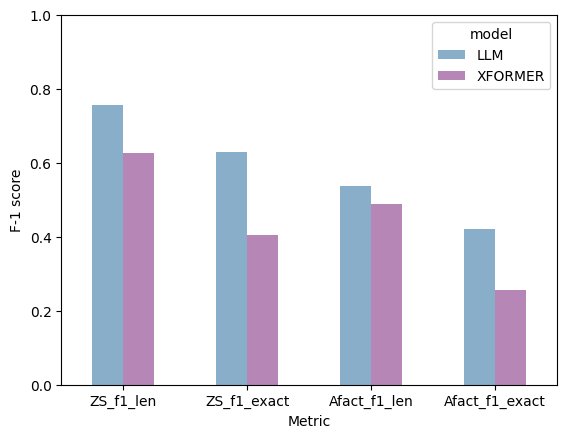

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(df_plot, x = 'metric', y = 'score', hue = 'model', palette = ["#7eb0d5", "#bd7ebe"], width = 0.5)
ax.set_ylim(0,1)
ax.set(xlabel = 'Metric', ylabel = 'F-1 score')
# plt.savefig('llm_vs_transfomrers_errors.pdf')